In [150]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [24]:
# 한글 깨짐
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [266]:
train_raw = pd.read_csv('train.csv',encoding = 'utf-8')
test_raw = pd.read_csv('test.csv',encoding = 'utf-8')
train = train_raw
test = test_raw

In [267]:
#메뉴는 일단 제외
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [268]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   중식계             1205 non-null   float64
 8   석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 84.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가

In [269]:
#train.describe
print(train.isnull().sum())
print(test.isnull().sum())

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
중식계               0
석식계               0
dtype: int64
일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
dtype: int64


In [270]:
#날짜 전처리;
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['year'] = train['일자'].dt.year
train['month'] = train['일자'].dt.month
train['day'] = train['일자'].dt.day

test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day

#요일 라벨 인코딩
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

#내부근무자수 생성
train['내부근무자수'] = train['본사정원수']-train['본사휴가자수']-train['본사출장자수']-train['현본사소속재택근무자수']
test['내부근무자수'] = test['본사정원수']-test['본사휴가자수']-test['본사출장자수']-test['현본사소속재택근무자수']

In [271]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  day             1205 non-null   int64         
 12  내부근무자수          1205 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 122.5 KB


<AxesSubplot:>

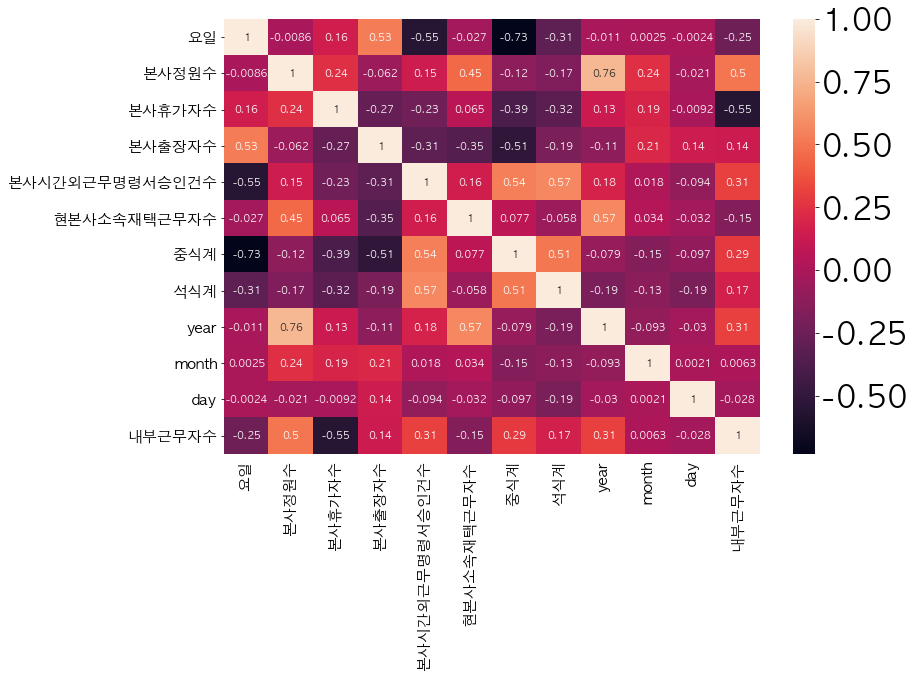

In [272]:
#상관관계 분석
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.corr(), annot = True)
#중식계와 유의미한 변수 : 요일, 본사시간외근무명령서승인건수(야근),본사출장자수/석식계 ,본사휴가자수 
#석식계와 유의미한 변수 : 본사시간외근무명령서승인건수, 중식계, 본사휴가자수 

<AxesSubplot:>

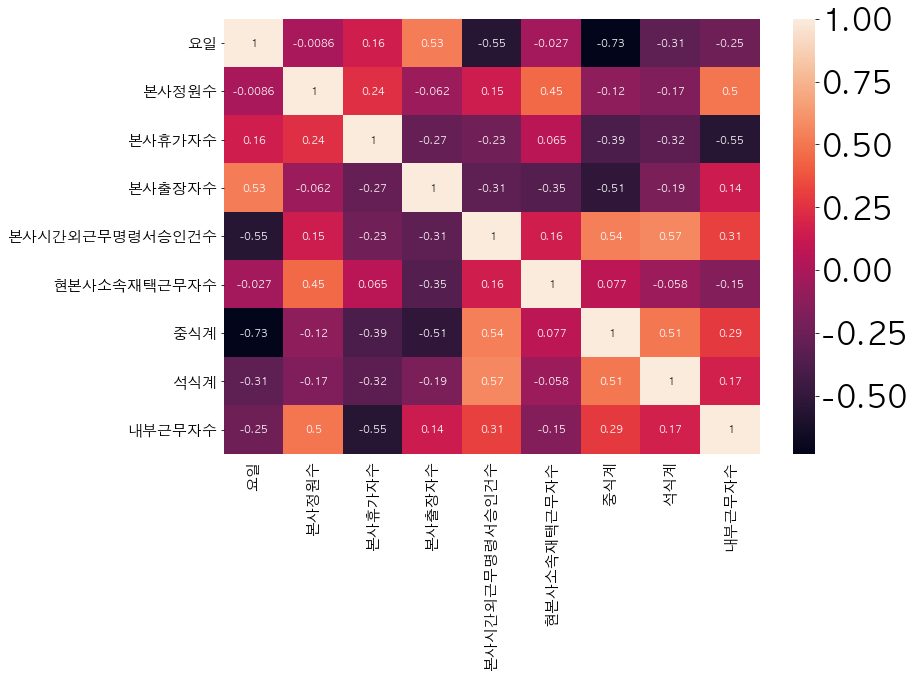

In [273]:
#요일 제외 유의미하지 않으니 year,month,day제외하고 heatmap
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.drop(['year','month','day'],axis = 1).corr(),annot = True)

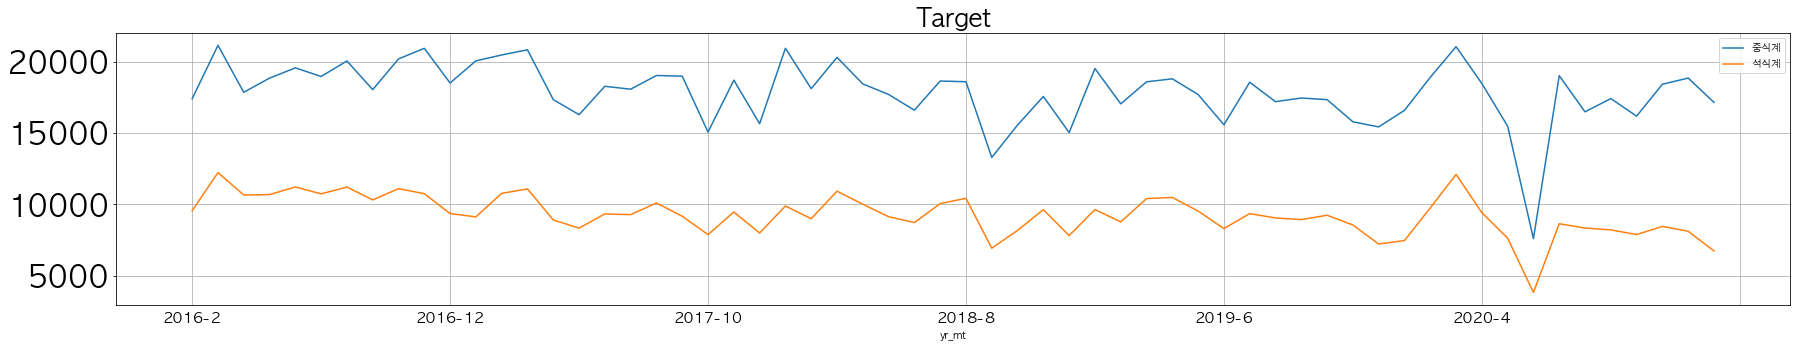

In [282]:
#일자에 따른 중석식계 시각화
mt_wk_hm = train.groupby(['year','month'])['중식계','석식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
mt_wk_hm.plot(x = 'yr_mt', y = ['중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.title('Target', fontsize = 25)
plt.show()

- 시각화 결과 2020년 4월 이후 중석식계 모두 감소가 있었다. 그 이유는 무엇일까?
    - 예상1) 내부근무자수 감소(= 출장자 + 휴가자수 증가 or 재택근무자수 증가)
    - 예상2) 본사 정원수 감소

## 1.내부근무자수

<AxesSubplot:xlabel='내부근무자수', ylabel='Density'>

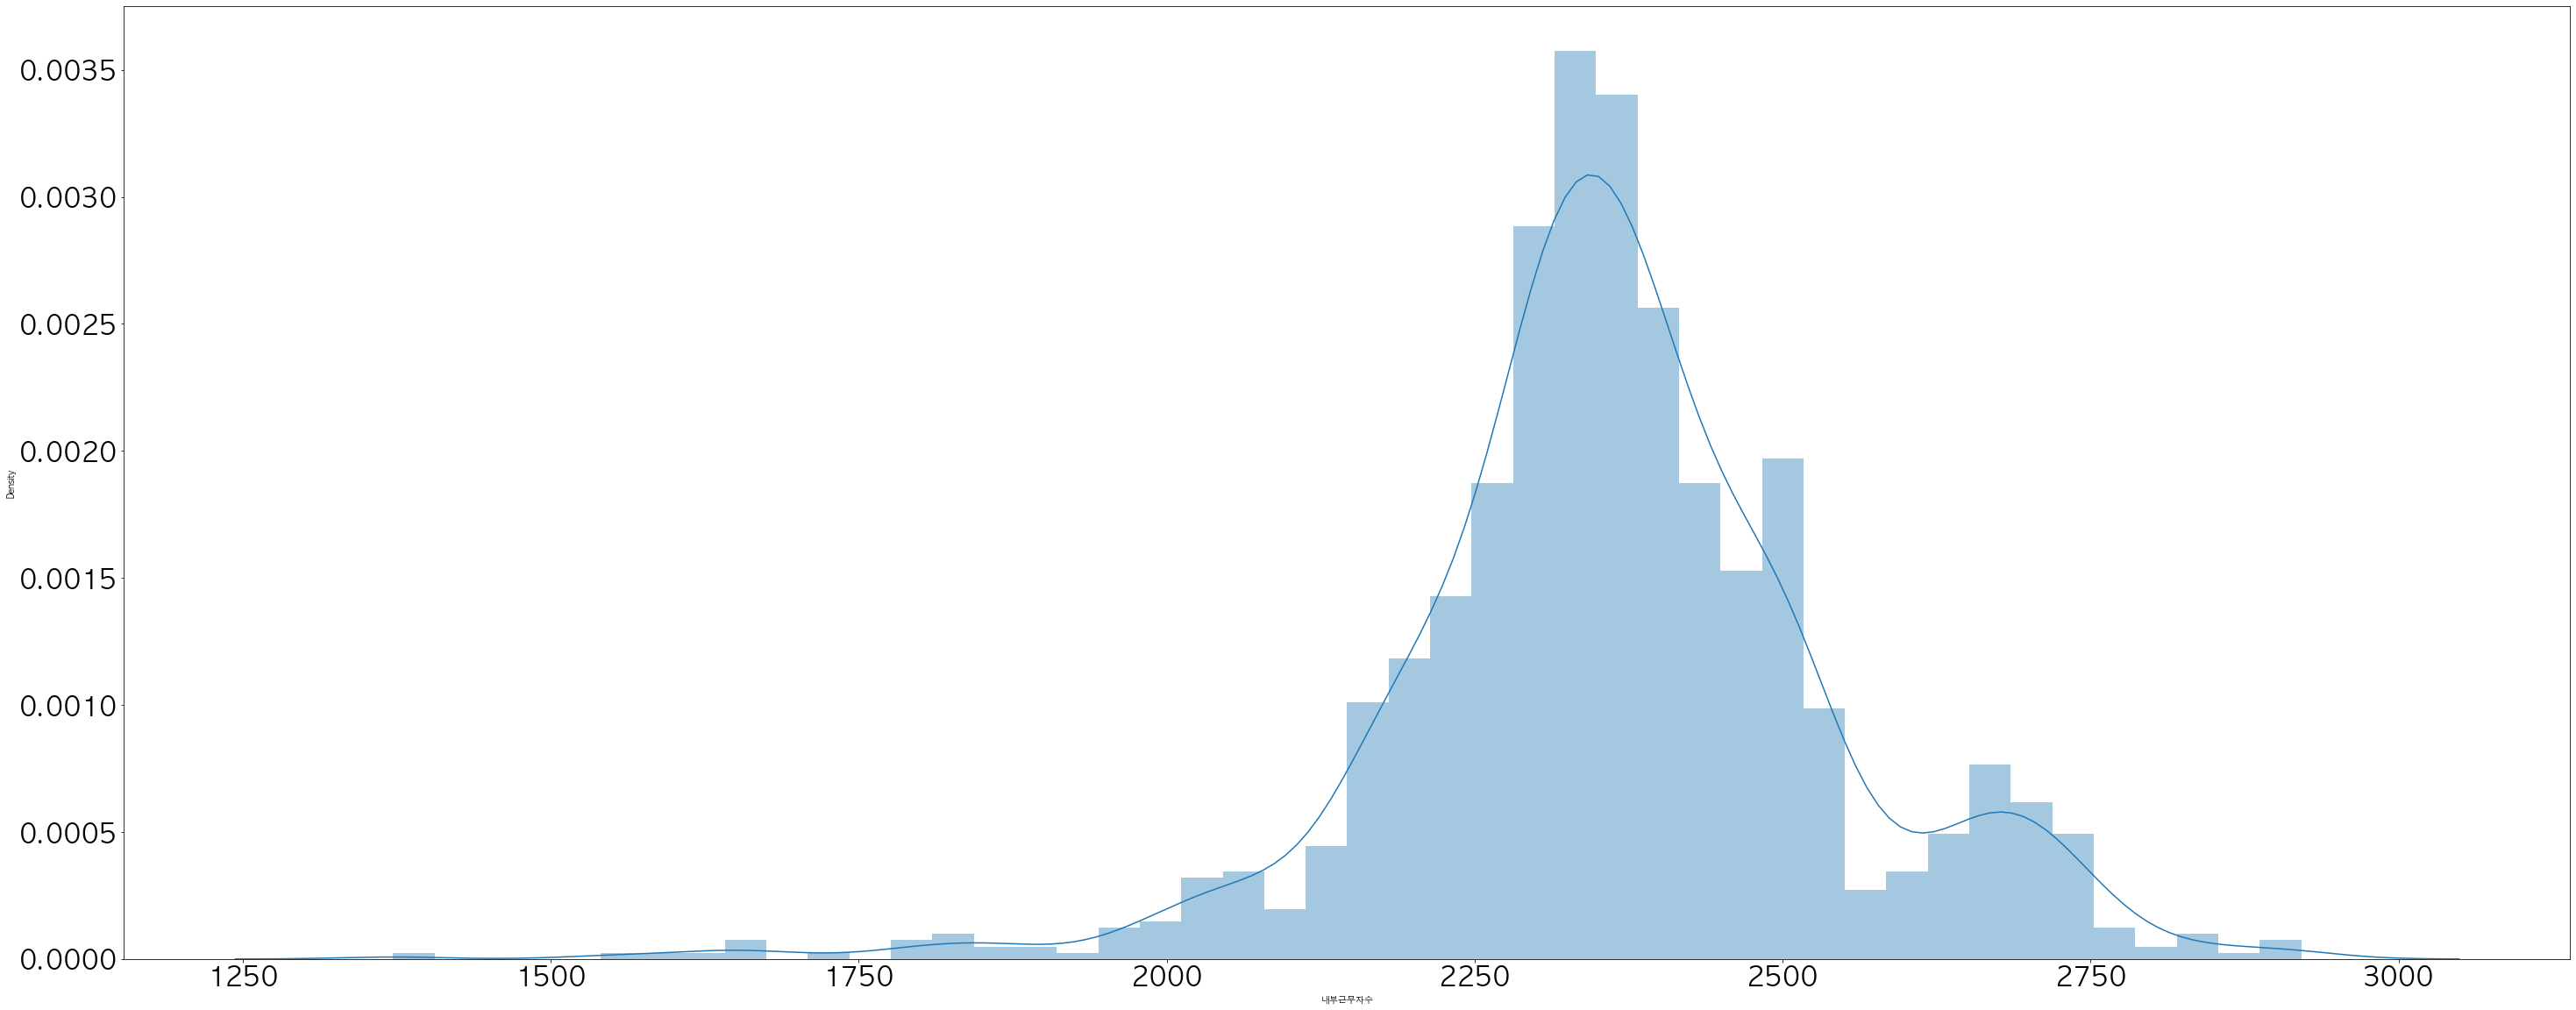

In [299]:
#내부근무자 수 분포
sns.distplot(train.내부근무자수)

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

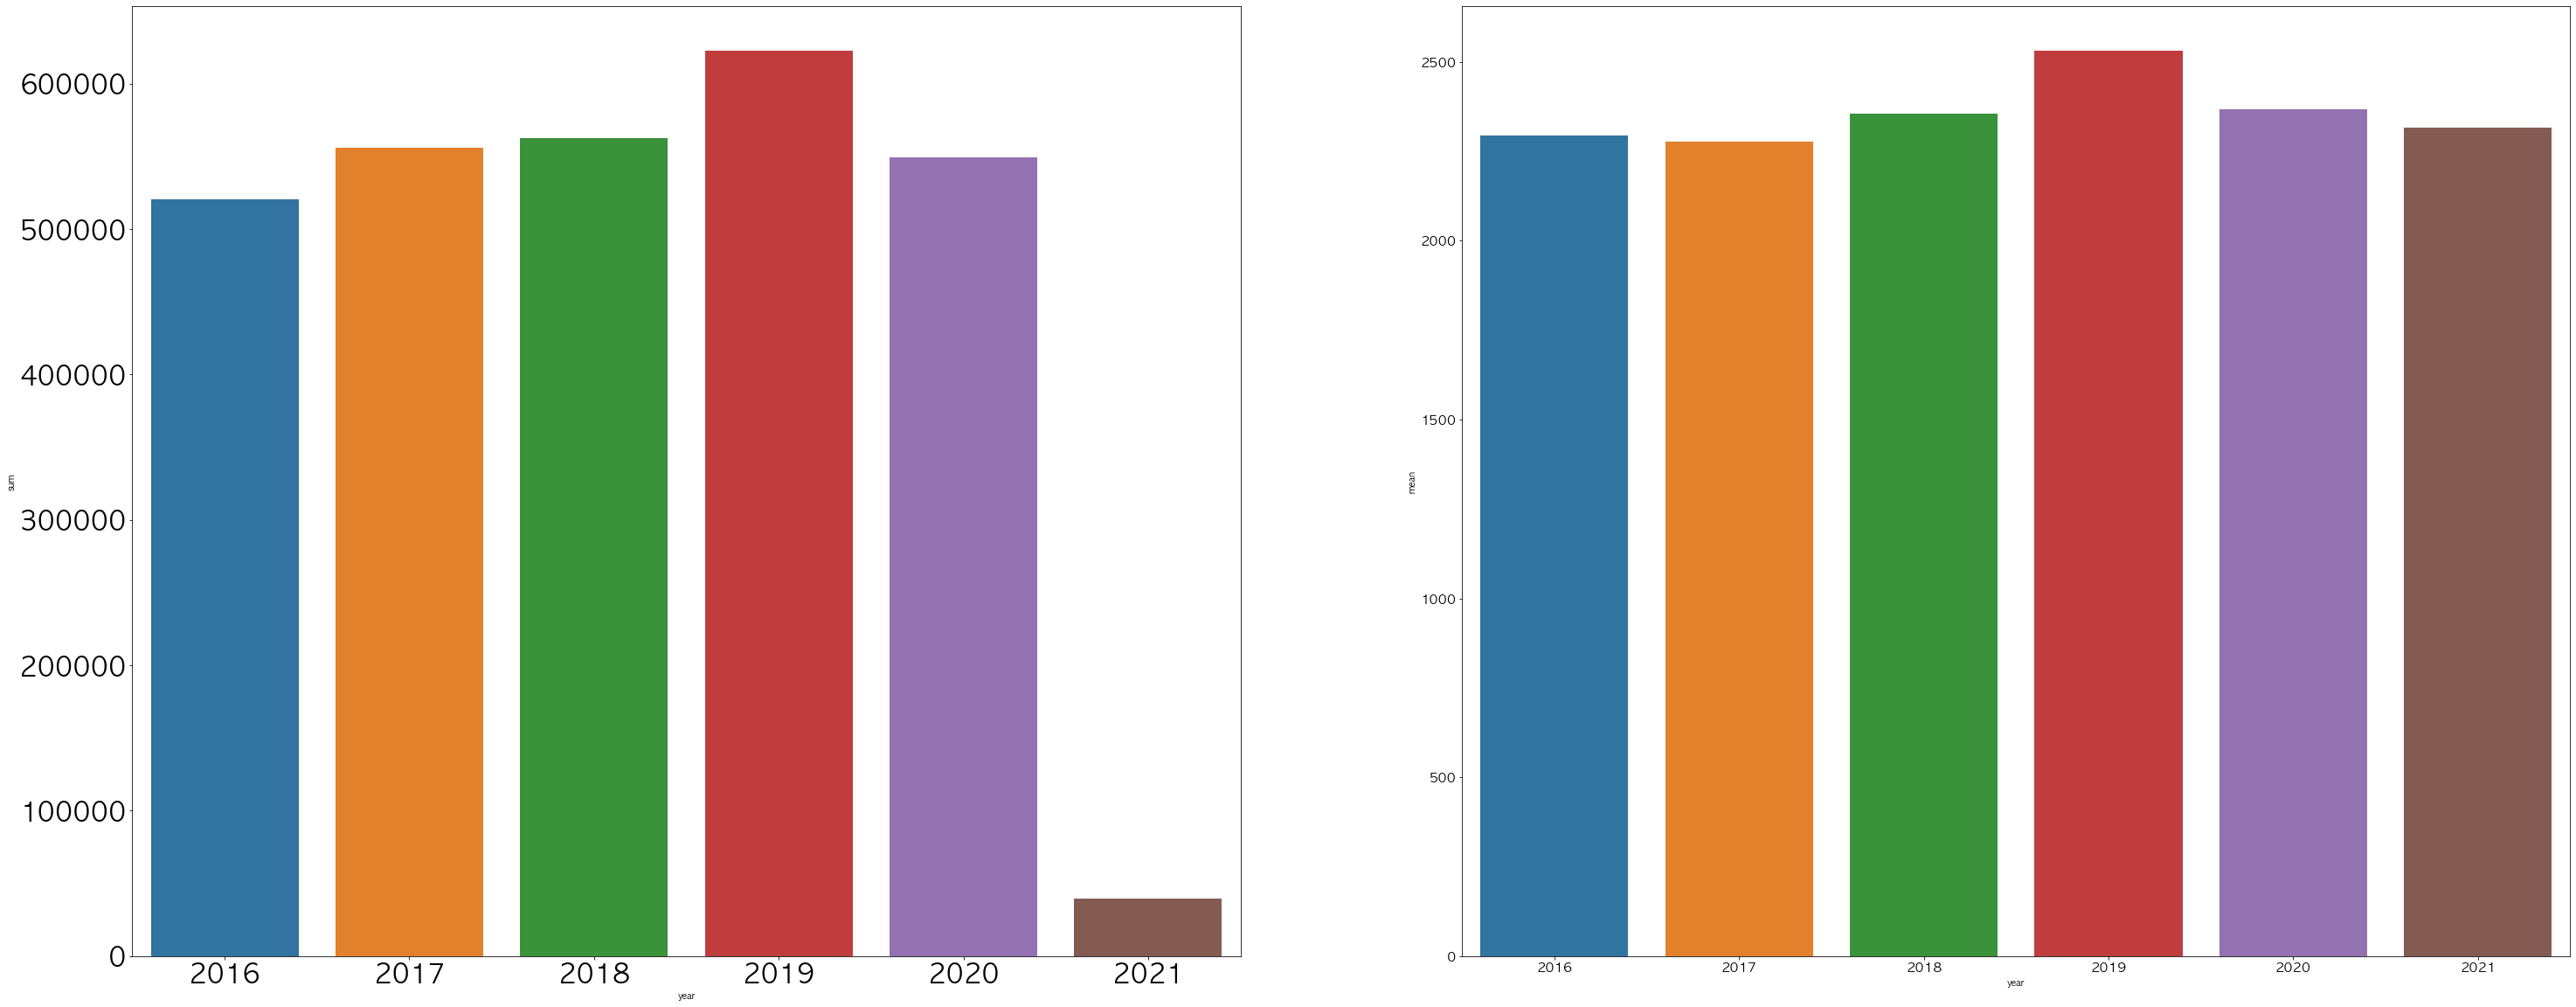

In [312]:
#년도별 내부근무자 수
yr_wk_cp = train.groupby('year')['내부근무자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_cp, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_cp, x = 'year', y= 'mean',ax = ax[1])

년도별로 확인해보니 2019년보다 이후 조금 감소하였다.
보다 정확히 확인하기 위하여 월별로 확인해보자

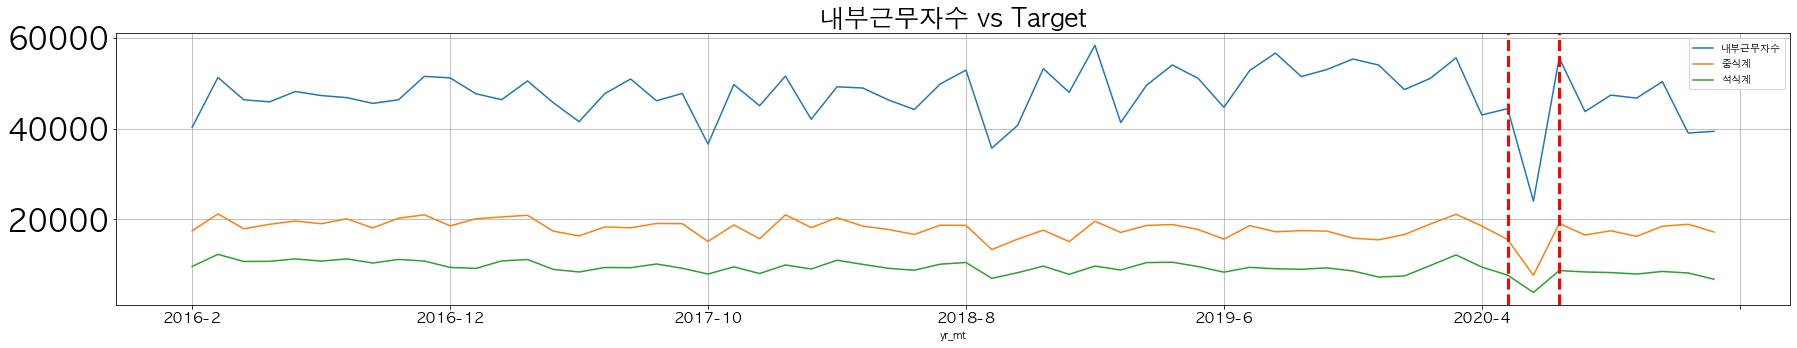

In [341]:
#년/월 내부근무자수에 따른 중석식계의 영향은?
mt_wk_cp = train.groupby(['year','month'])['내부근무자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_cp['yr_mt'] = mt_wk_cp['year'].astype(str)+ '-' + mt_wk_cp['month'].astype(str)
mt_wk_cp.plot(x = 'yr_mt', y = ['내부근무자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('내부근무자수 vs Target', fontsize = 25)
plt.show()

- 시각화결과 같은 시기에 내부근무자수들 또한 감소하였다. 이것이 해당시기에 중석식계가 감소한 이유로 추측된다.
- 그렇다면 내부근무자수가 감소한 이유는?  
    예상1)재택근무자수 증가  
    예상2)출장자수 증가  
    예상3)휴가자수 증가  

### 1-1-1.재택근무자수
재택근무자수는 2020년 3월 이후에 존재한다 > 코로나 영향일 가능성 큼  

<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='Density'>

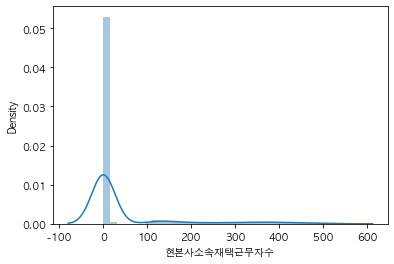

In [101]:
sns.distplot(train.현본사소속재택근무자수)
#0 > 재택근무하는 인원이 없었음

<AxesSubplot:xlabel='year', ylabel='현본사소속재택근무자수'>

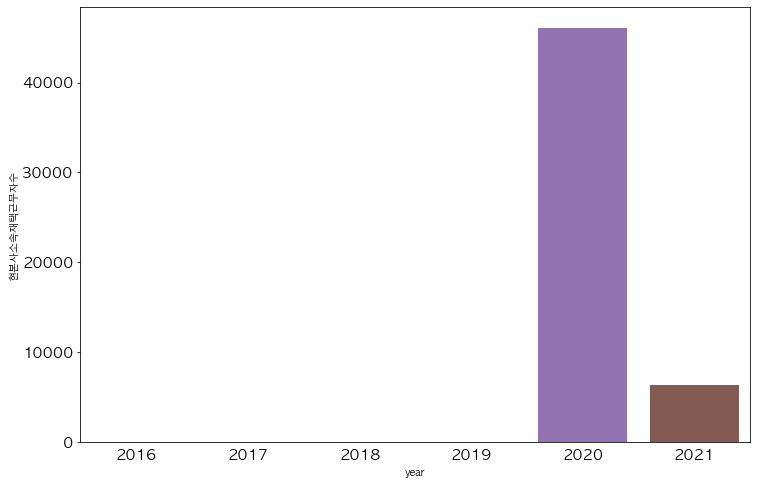

In [264]:
#년도별로 재택근무자수 확인 > 2020년 이전에는 재택근무자수 없음.
yr_wk_hm = train.groupby('year')['현본사소속재택근무자수'].agg('sum').reset_index()
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_hm, x = 'year', y= '현본사소속재택근무자수')

<AxesSubplot:xlabel='일자', ylabel='현본사소속재택근무자수'>

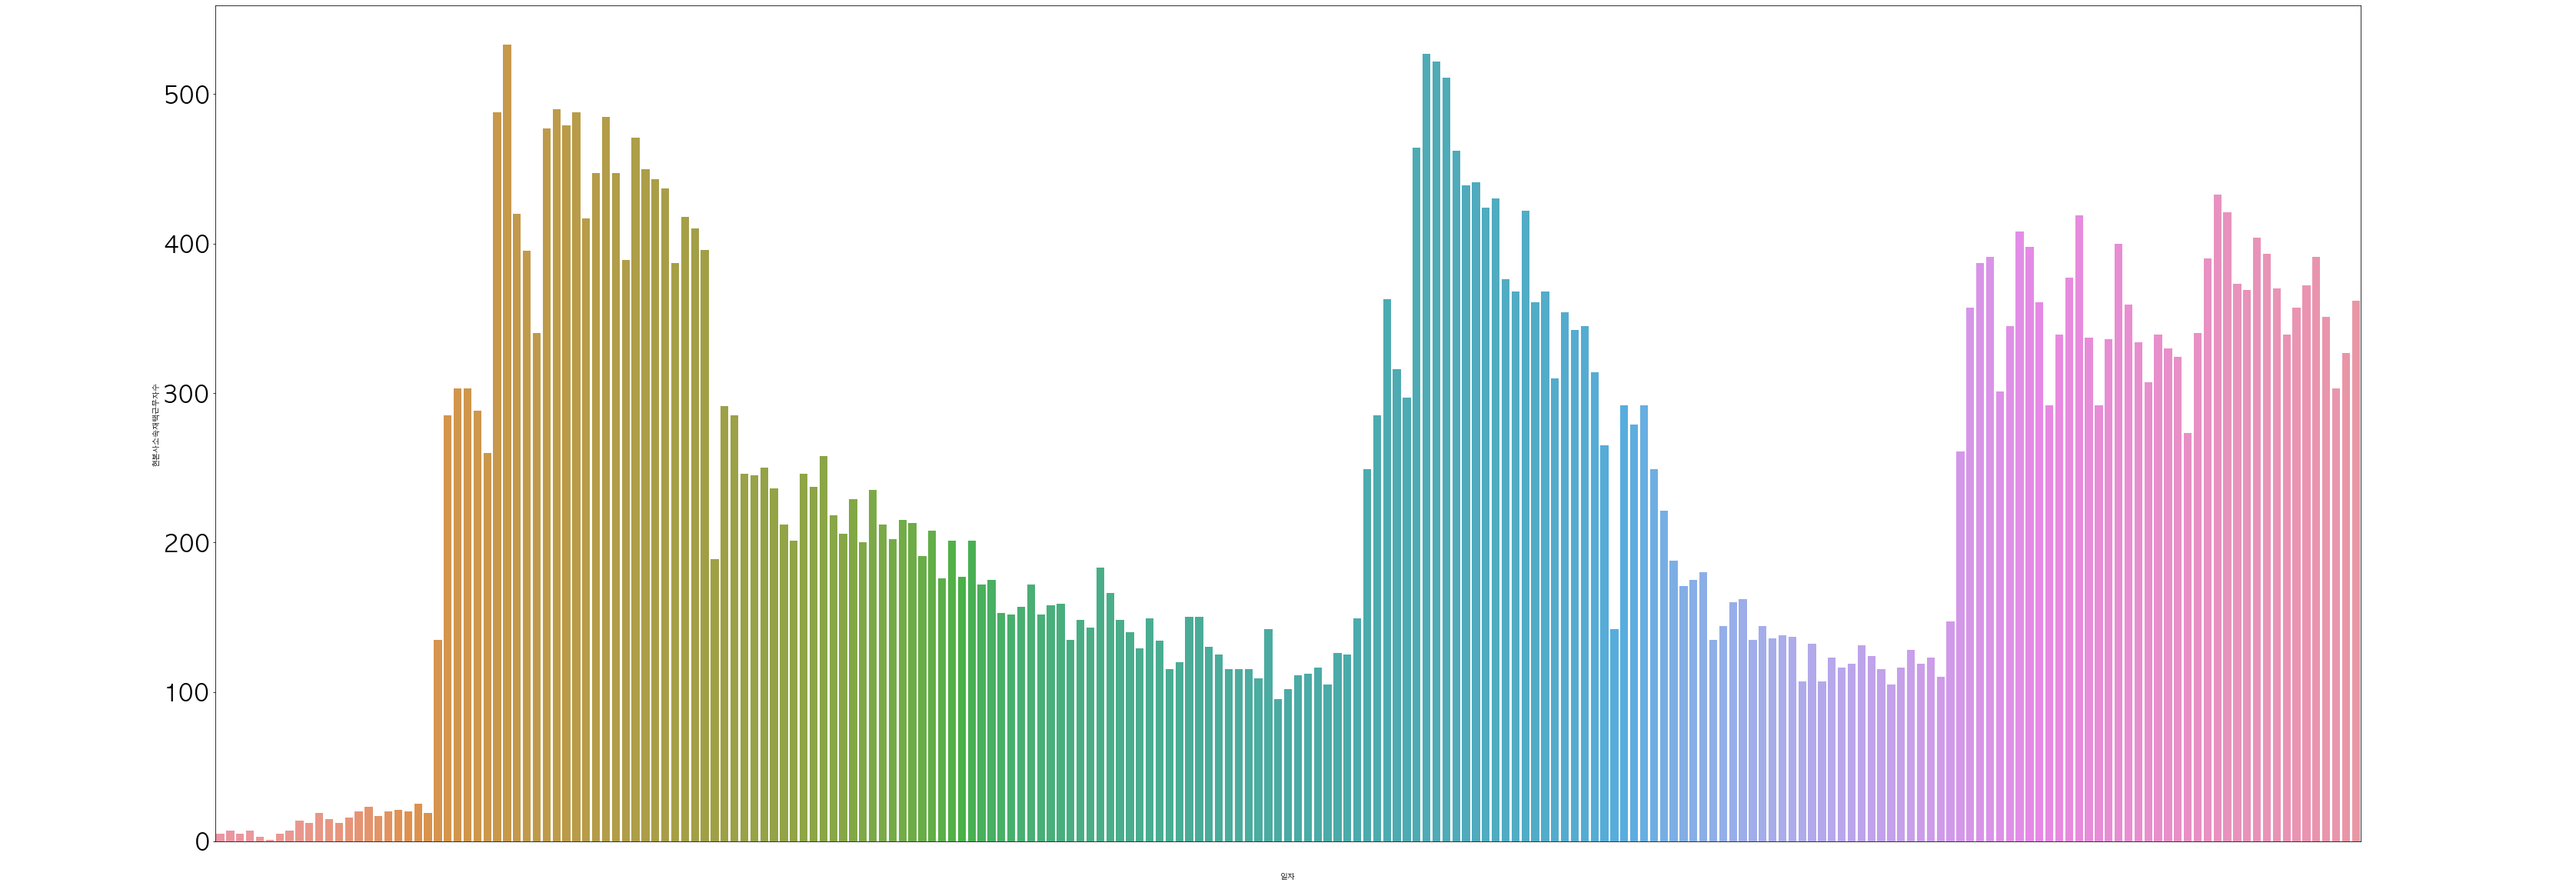

In [166]:
#그렇다면 일자별로 재택근무자수는?
wk_home = train[train['현본사소속재택근무자수']>0][['일자','현본사소속재택근무자수']]
plt.rcParams['figure.figsize'] = [50, 20]
plt.rc('xtick', labelsize=30,color = 'white') # fontsize of the tick labels
#plt.xticks(rotation=90)
plt.rc('ytick', labelsize=30) # fontsize of the tick labels
sns.barplot(data = wk_home,x = '일자', y = '현본사소속재택근무자수')

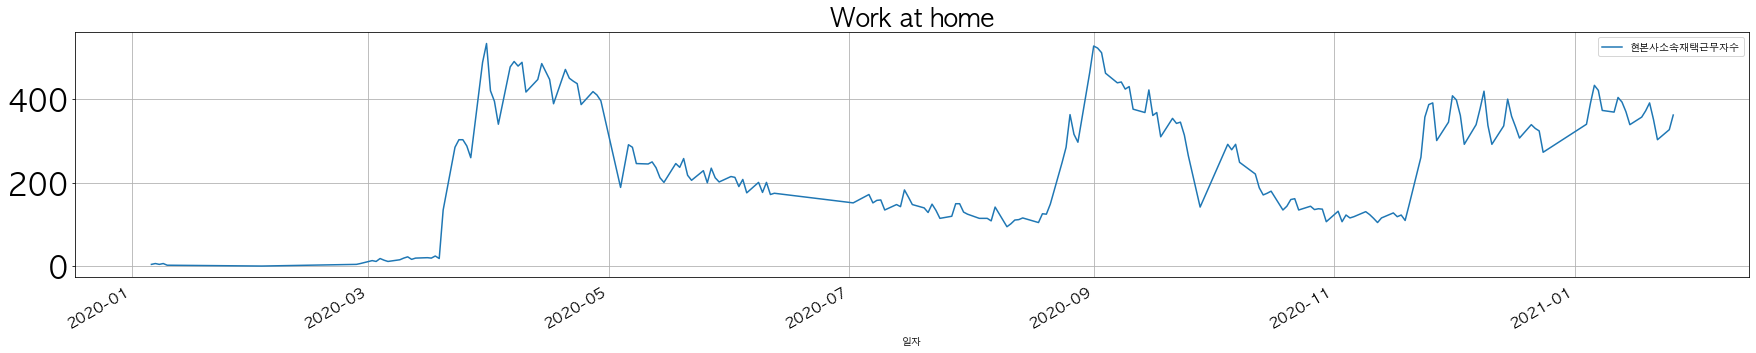

In [204]:
wk_home = train[train['현본사소속재택근무자수']>0][['일자','현본사소속재택근무자수']]
wk_home.plot(x = '일자', y = '현본사소속재택근무자수', figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.title('Work at home', fontsize = 25)
plt.show()

    year  month  현본사소속재택근무자수      중식계    yr_mt
47  2020      1         27.0  16606.0   2020-1
48  2020      2         13.0  18924.0   2020-2
49  2020      3       2848.0  21078.0   2020-3
50  2020      4       8686.0  18493.0   2020-4
51  2020      5       4398.0  15496.0   2020-5
52  2020      6       1929.0   7600.0   2020-6
53  2020      7       3368.0  19040.0   2020-7
54  2020      8       3611.0  16502.0   2020-8
55  2020      9       7723.0  17433.0   2020-9
56  2020     10       3445.0  16201.0  2020-10
57  2020     11       3857.0  18440.0  2020-11
58  2020     12       6225.0  18873.0  2020-12
59  2021      1       6295.0  17165.0   2021-1


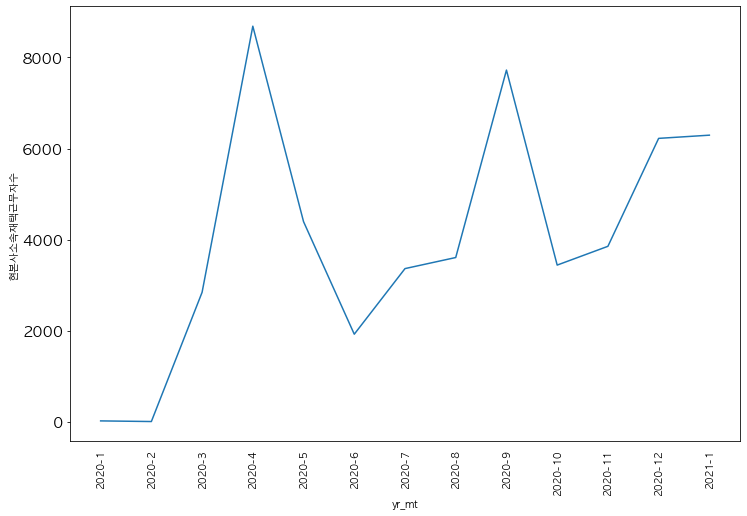

In [284]:
#월별로 묶어서 재택근무자수 보기
mt_wk_hm = train.groupby(['year','month'])['현본사소속재택근무자수','중식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 10, rotation =90)
plt.yticks(color = "black", fontsize = 15)
sns.lineplot(data = mt_wk_hm[mt_wk_hm['현본사소속재택근무자수']>0], x = 'yr_mt',y= '현본사소속재택근무자수')
print(mt_wk_hm[mt_wk_hm['현본사소속재택근무자수']>0])

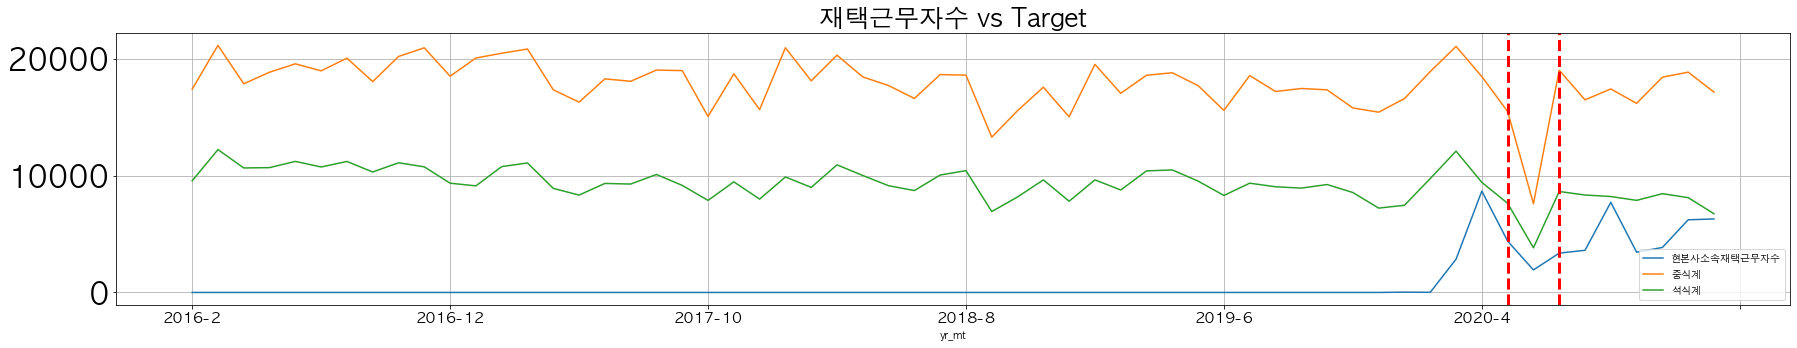

In [342]:
#재택근무자수에 따른 중석식계의 영향은?
mt_wk_hm = train.groupby(['year','month'])['현본사소속재택근무자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_hm['yr_mt'] = mt_wk_hm['year'].astype(str)+ '-' + mt_wk_hm['month'].astype(str)
mt_wk_hm.plot(x = 'yr_mt', y = ['현본사소속재택근무자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('재택근무자수 vs Target', fontsize = 25)
plt.show()

-시각화 결과에 따르면 중석식계가 감소한 시기에 재택근무자수도 감소하였으니 이는 원인이 아니라고 예상된다

### 1-1-2.출장자 수

<AxesSubplot:xlabel='본사출장자수', ylabel='Density'>

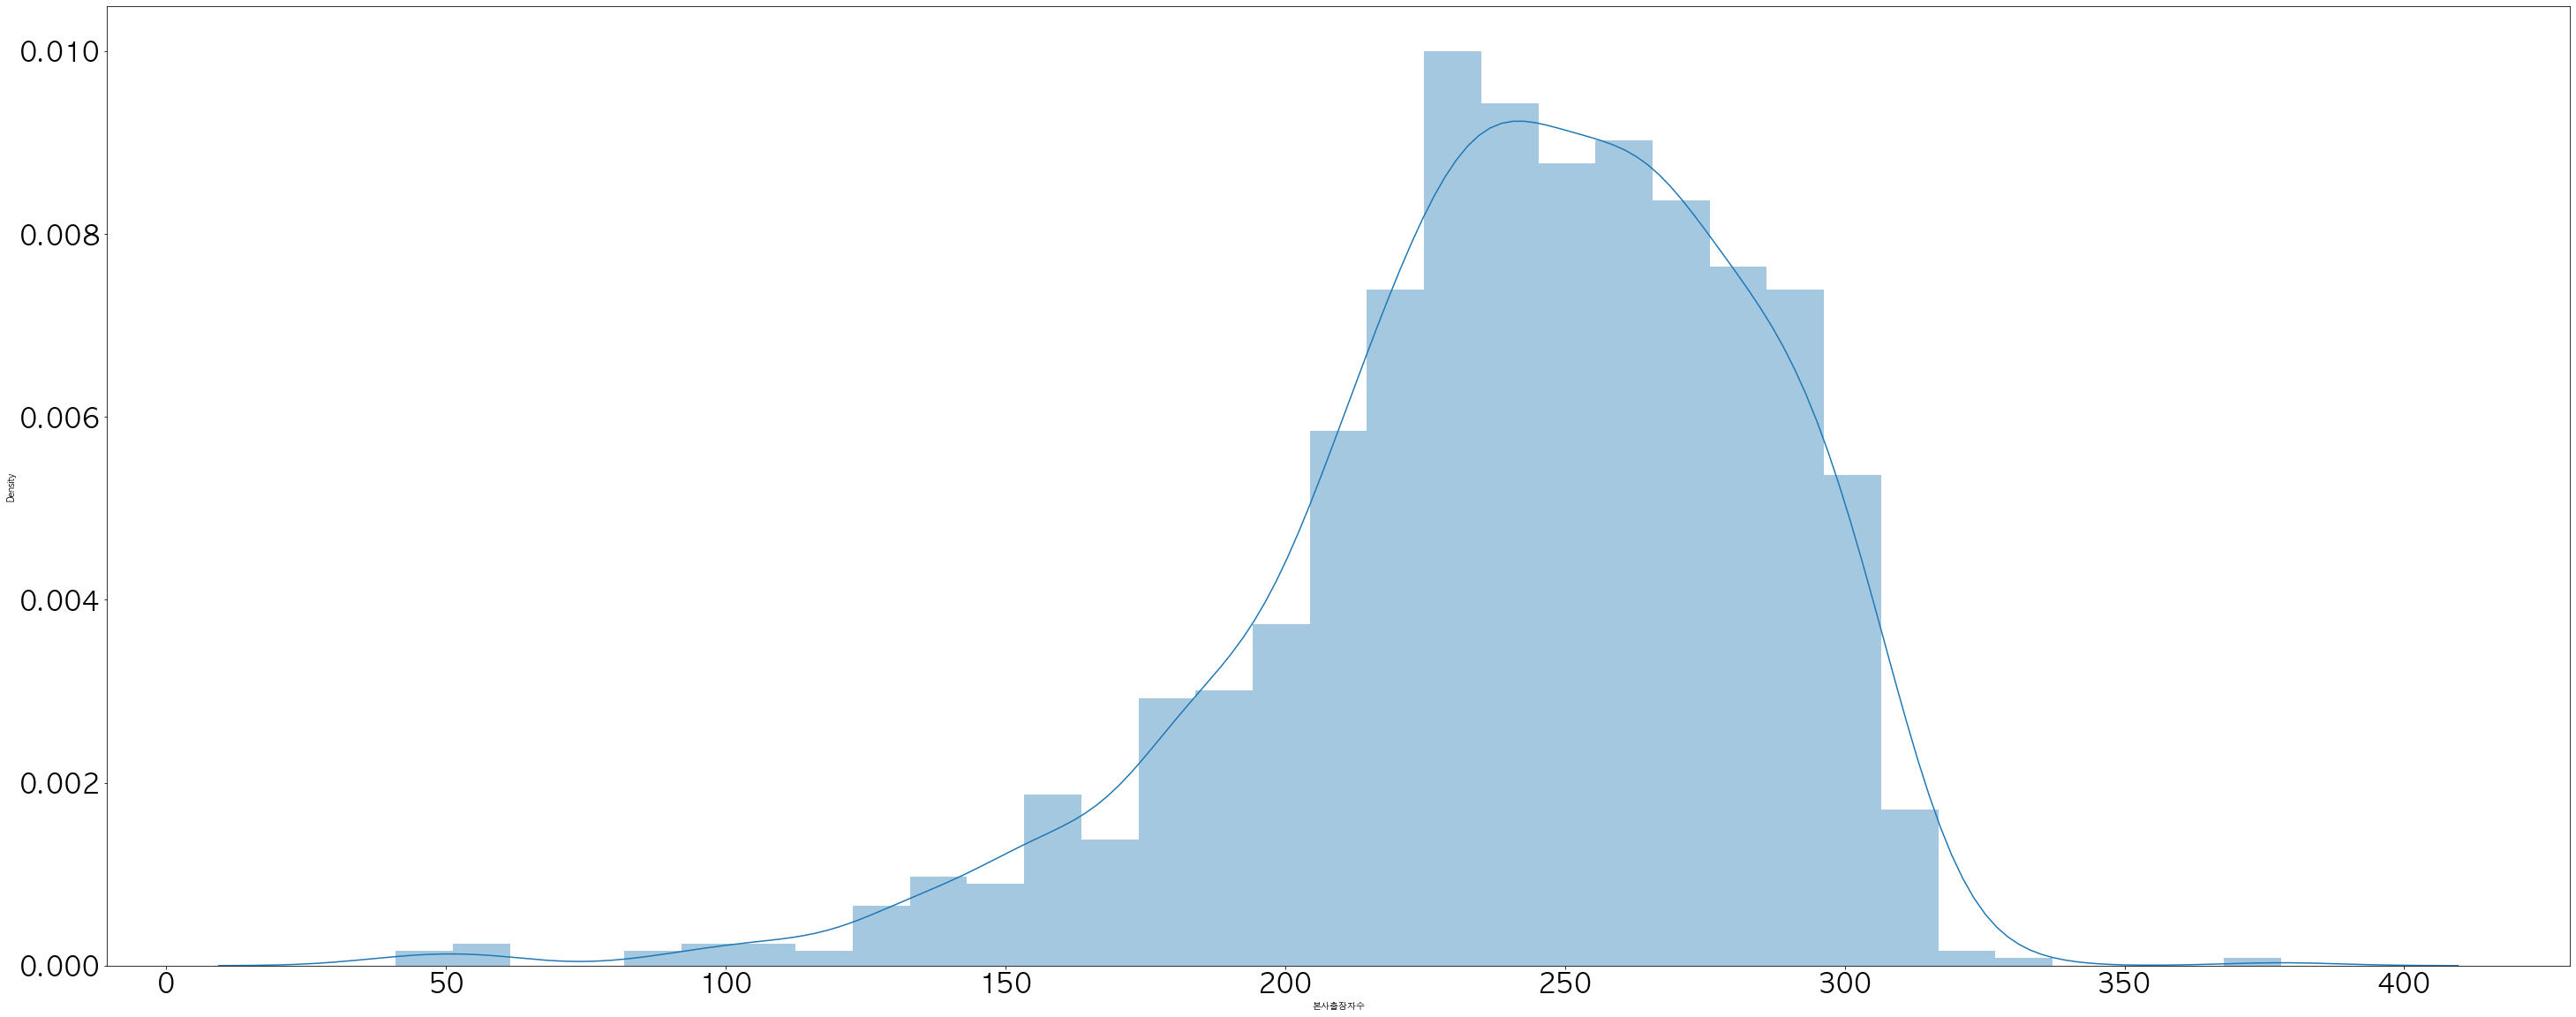

In [298]:
#출장자 수 분포
sns.distplot(train.본사출장자수)

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

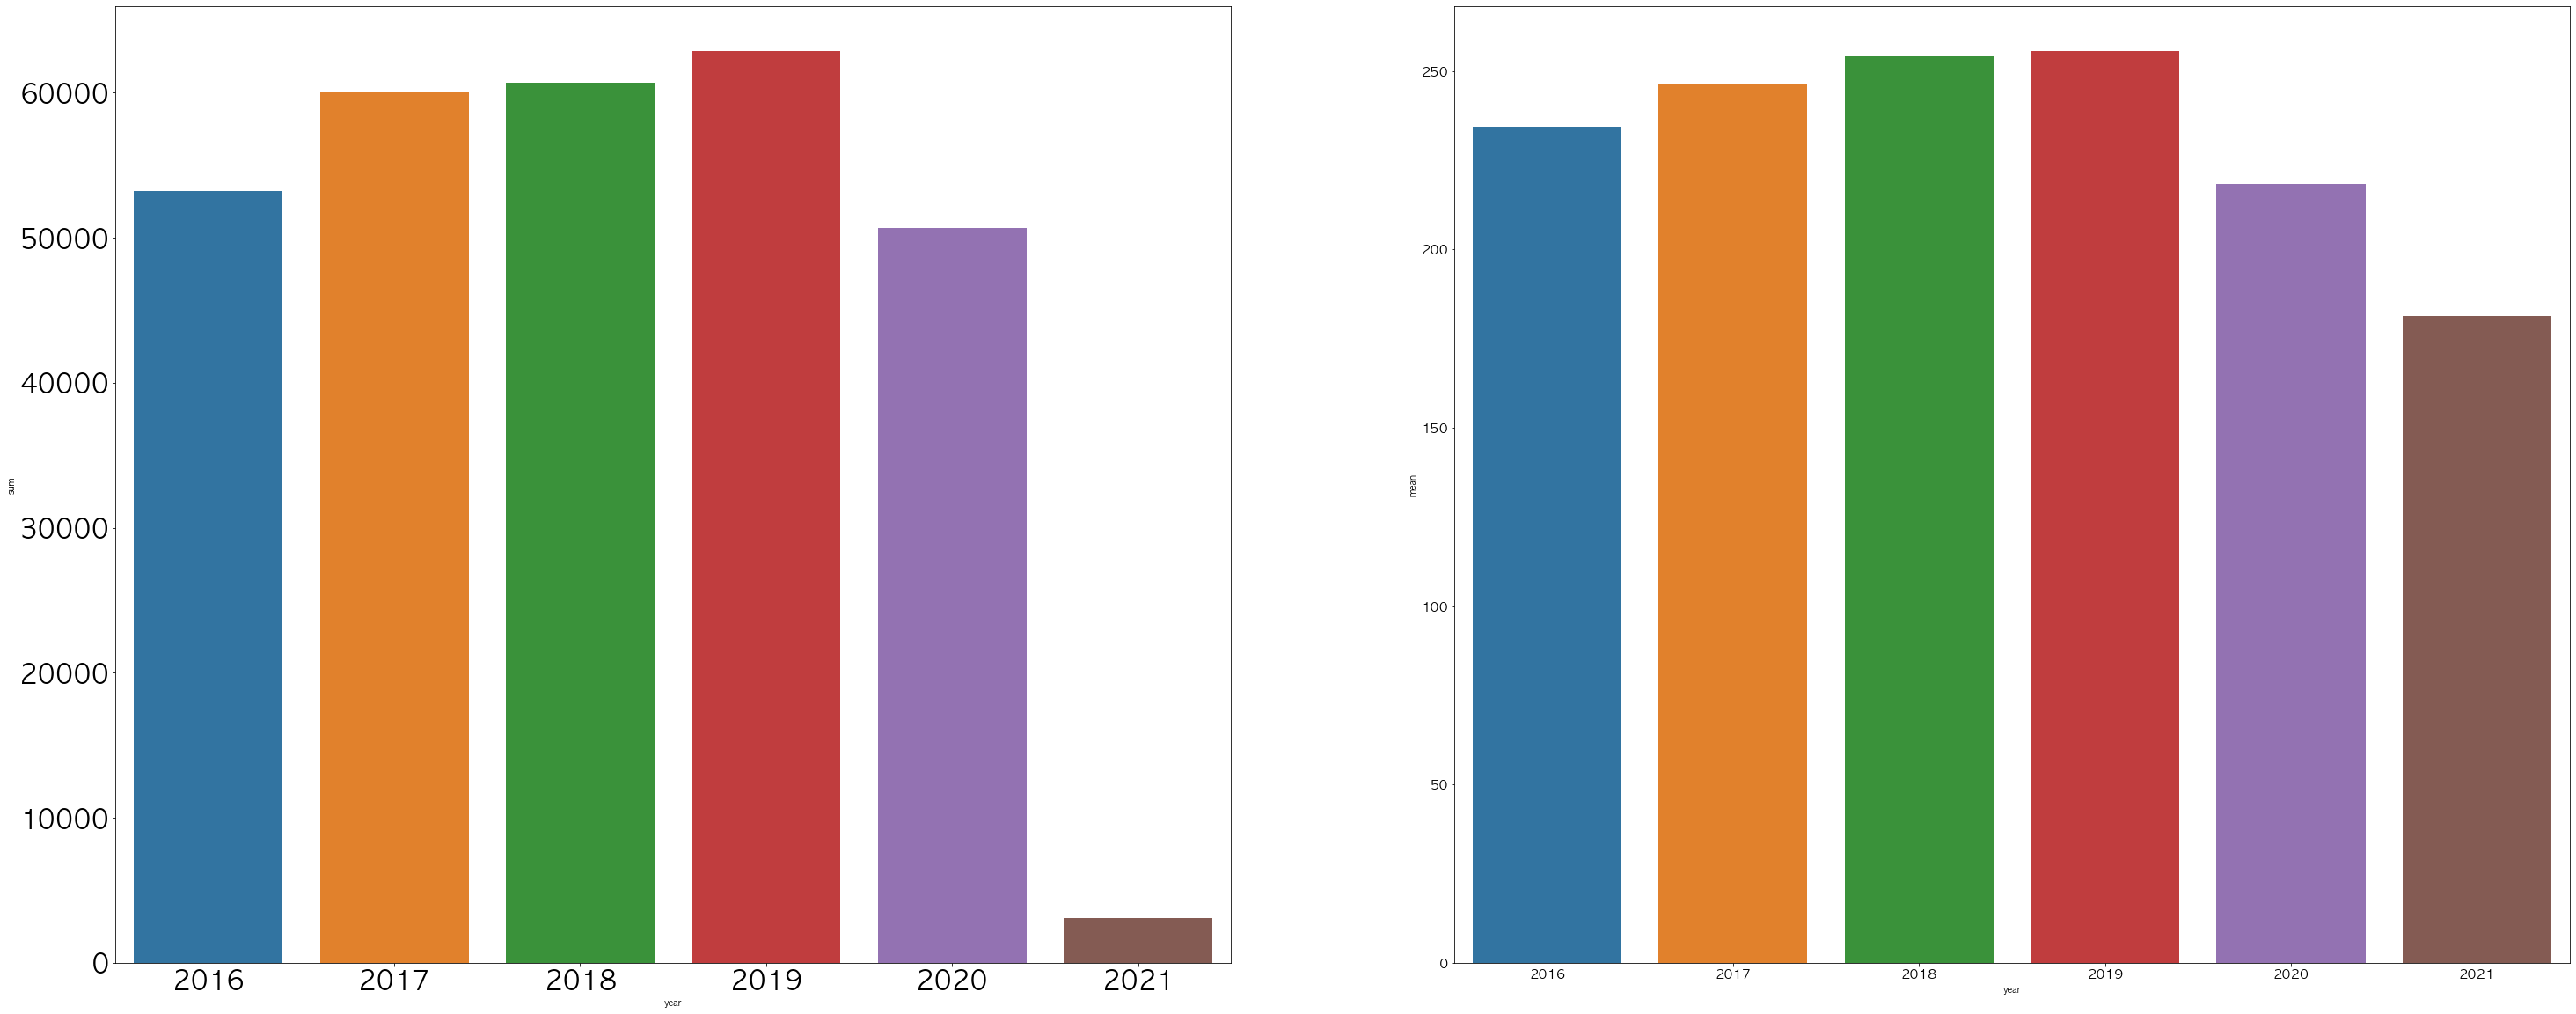

In [343]:
#년도별 본사출장자 수
yr_wk_bt = train.groupby('year')['본사출장자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_bt, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_bt, x = 'year', y= 'mean',ax = ax[1])

시각화결과 앞의 재택근무자수보다 19년도 이후 감소세가 존재하는 것으로 확인된다. 월별로 확인해보자

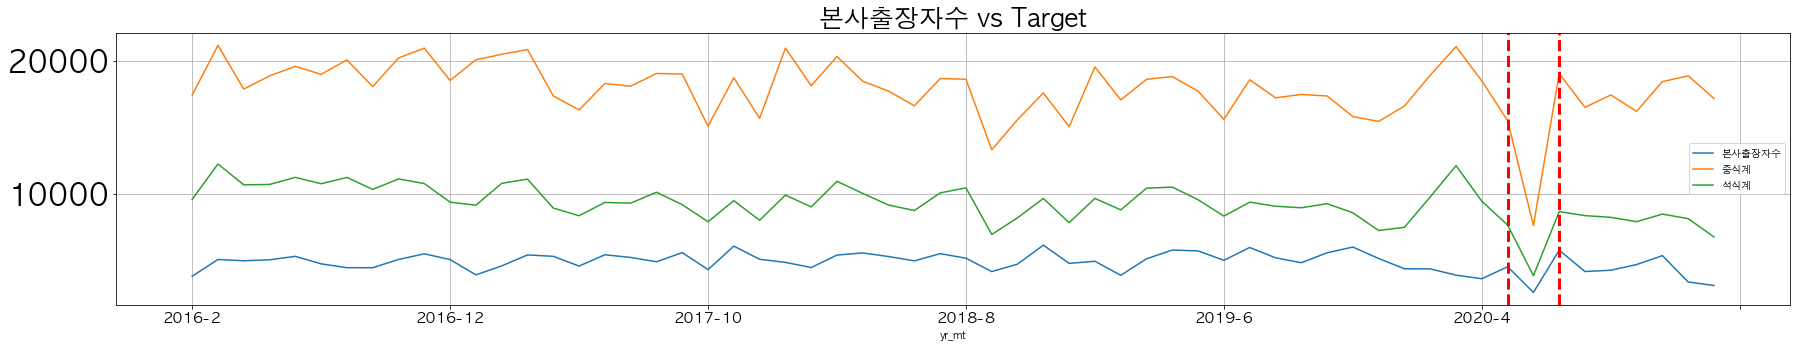

In [345]:
#년/월 본사출장자수에 따른 중석식계의 영향은?
mt_wk_bt = train.groupby(['year','month'])['본사출장자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_bt['yr_mt'] = mt_wk_bt['year'].astype(str)+ '-' + mt_wk_bt['month'].astype(str)
mt_wk_bt.plot(x = 'yr_mt', y = ['본사출장자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사출장자수 vs Target', fontsize = 25)
plt.show()

시각화 결과 재택근무자수와 마찬가지로 해당시기에 본사출장자수 또한 감소하였다.  
따라서 본사출장자수 또한 해당시기에 중석식계 감소에 직접적인 영향을 주는 변수는 아니라고 판단된다.  
!본사출장자수가 줄어든 원인도 확인이 필요하다

## 1-1-3.본사휴가자수

<AxesSubplot:xlabel='본사휴가자수', ylabel='Density'>

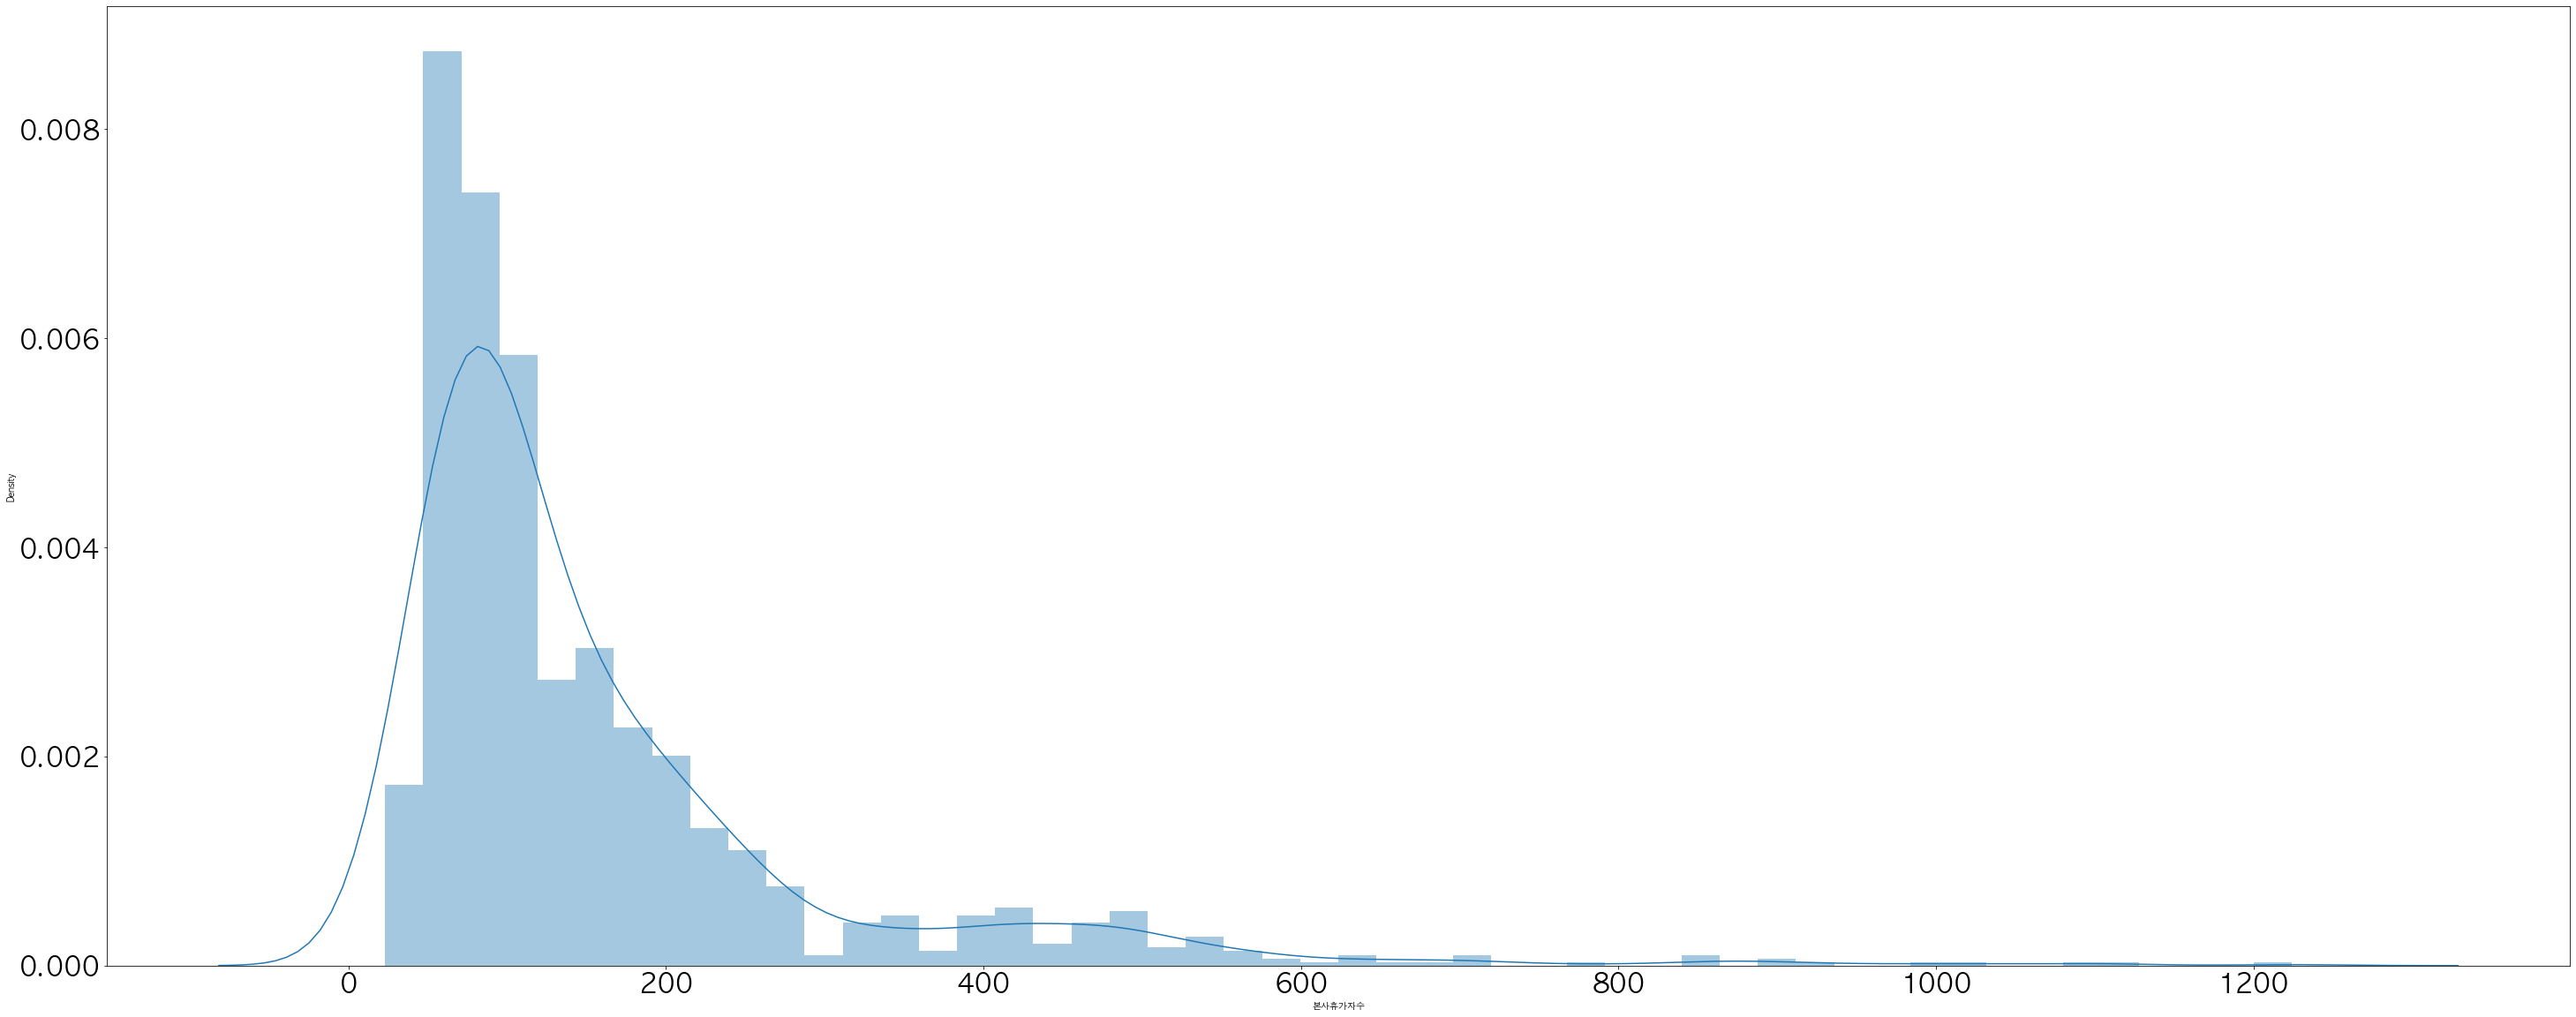

In [346]:
#휴가자 수 분포
sns.distplot(train.본사휴가자수)

휴가자 수는 앞의 변수들과 다르게 왼쪽으로 치우친 분포를 보인다

<AxesSubplot:xlabel='year', ylabel='mean'>

<Figure size 864x576 with 0 Axes>

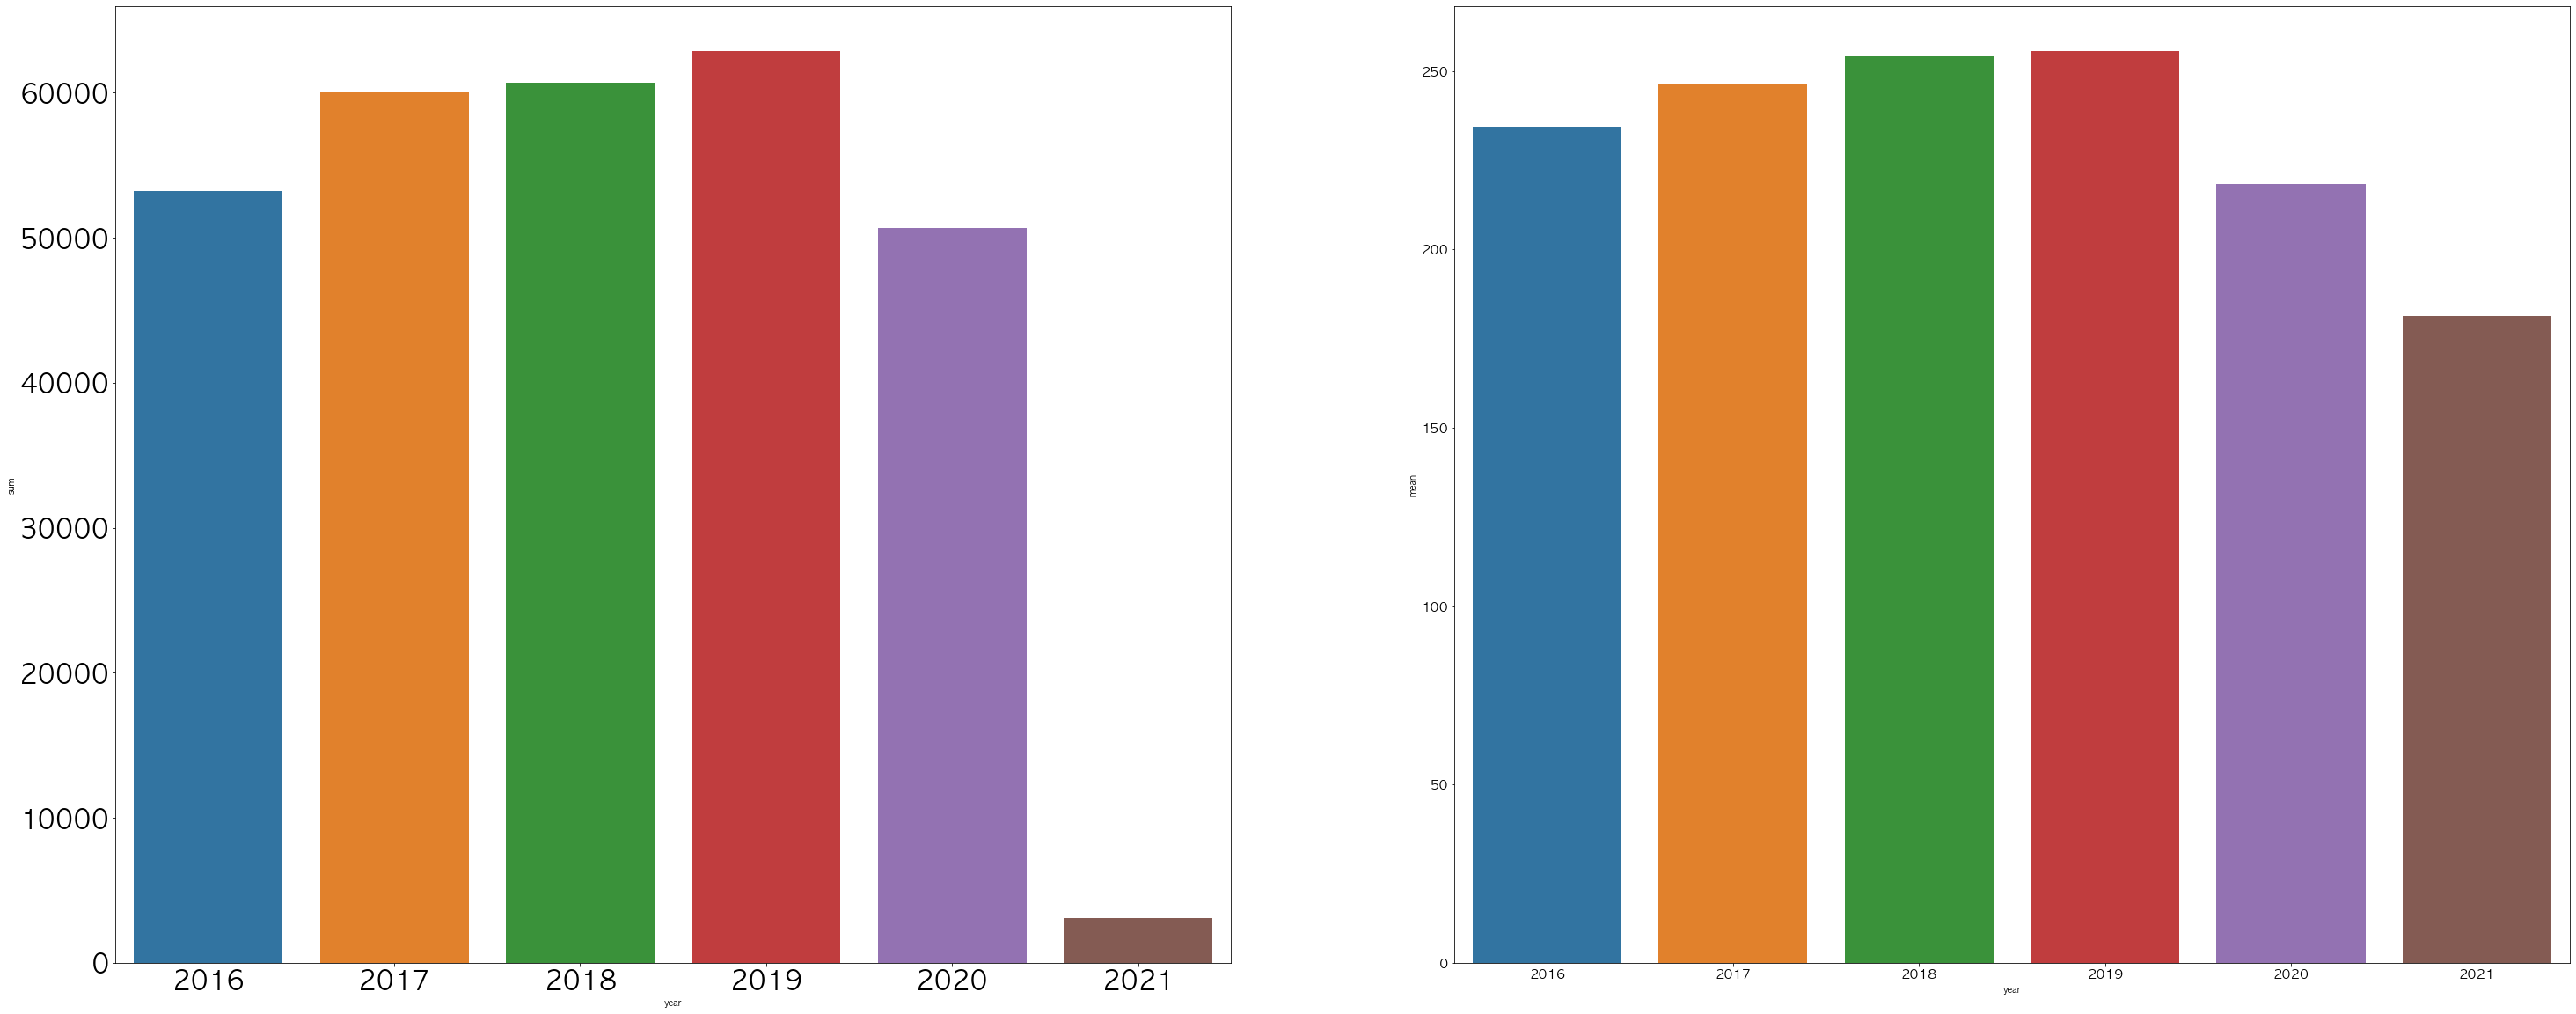

In [349]:
#년도별 본사휴가자 수
yr_wk_vc = train.groupby('year')['본사출장자수'].agg(['sum','mean']).reset_index()
plt.figure(figsize = (12,8))
fig, ax = plt.subplots(1,2)
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.barplot(data = yr_wk_vc, x = 'year', y= 'sum',ax = ax[0])
sns.barplot(data = yr_wk_vc, x = 'year', y= 'mean',ax = ax[1])

시각화 결과 휴가자 수 또한 19년도 이후 감소세가 있는 것으로 확인된다.

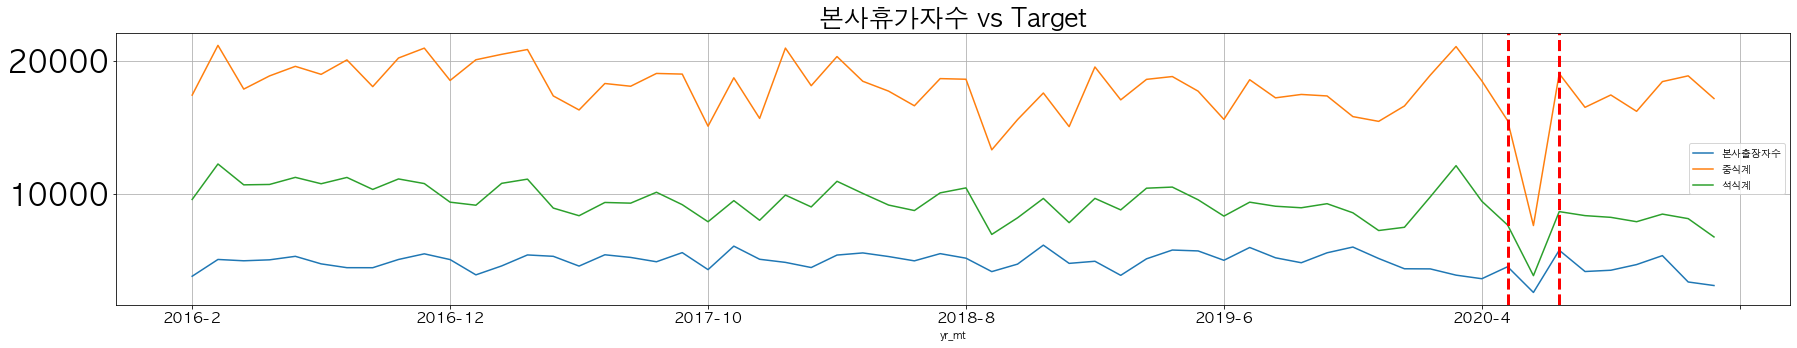

In [350]:
#년/월 본사휴가자수에 따른 중석식계의 영향은?
mt_wk_vc = train.groupby(['year','month'])['본사출장자수','중식계','석식계'].agg('sum').reset_index()
mt_wk_vc['yr_mt'] = mt_wk_vc['year'].astype(str)+ '-' + mt_wk_vc['month'].astype(str)
mt_wk_vc.plot(x = 'yr_mt', y = ['본사출장자수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사휴가자수 vs Target', fontsize = 25)
plt.show()

본사 휴가자수도 같은 시기에 감소하고 있으므로 이는 원인이 아니다.  
또한 휴가자수의 감소 원인이 추후에 파악이 필요하다

## 2.본사 정원수

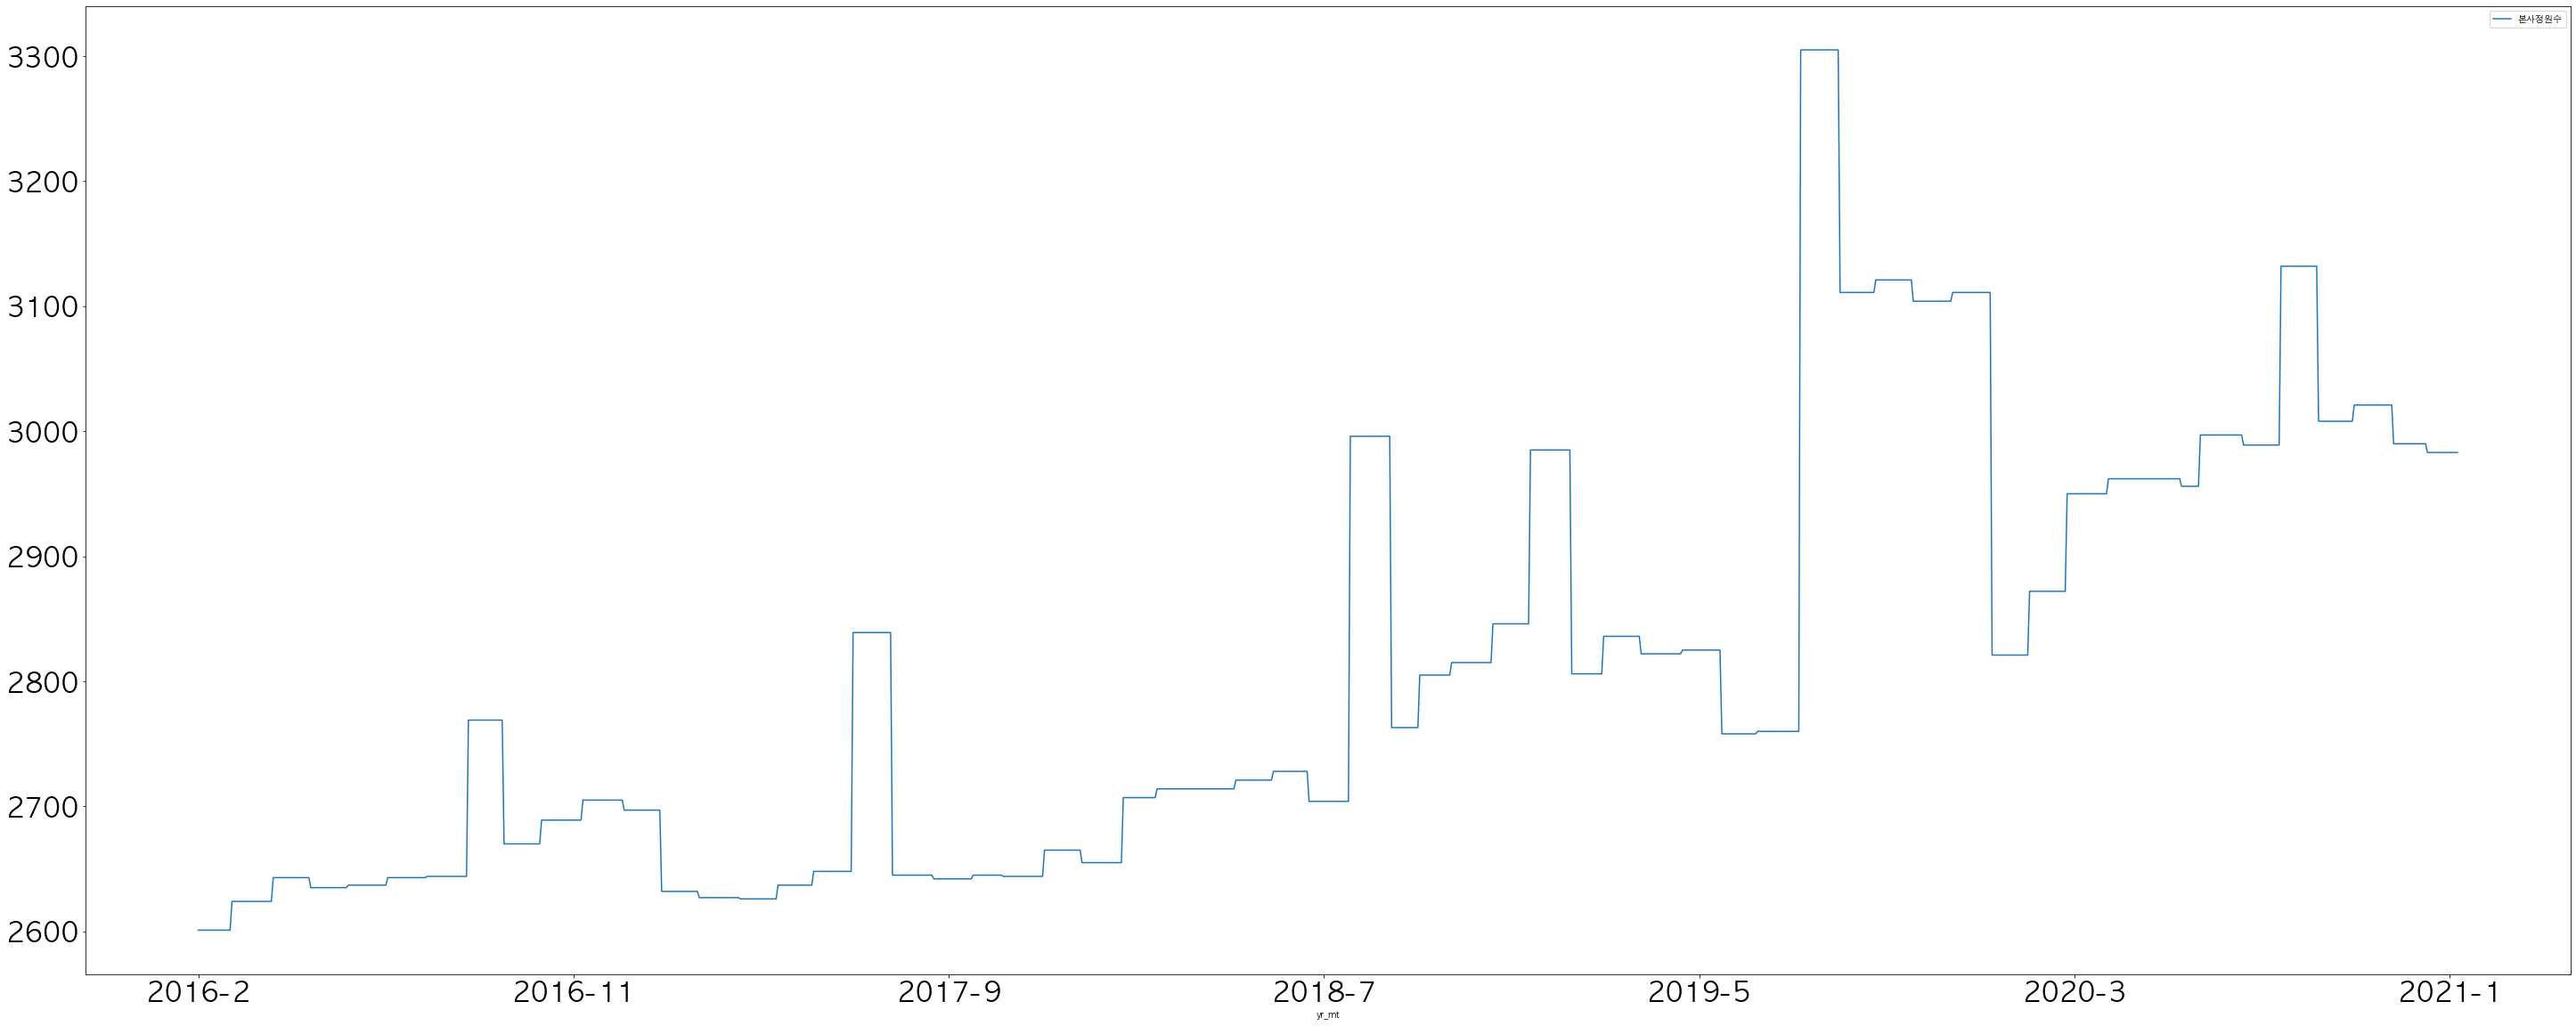

In [292]:
#본사정원수 시각화
train['yr_mt'] = train['year'].astype(str)+ '-' + train['month'].astype(str)
plt.rc('xtick', labelsize=30,color = 'black')
train.plot(x = 'yr_mt', y = '본사정원수')
plt.show()

시간이 지남에 따라 꾸준히 증가하고 있지만 중간중간 정원이 감소하는 이유는 무엇일까?  

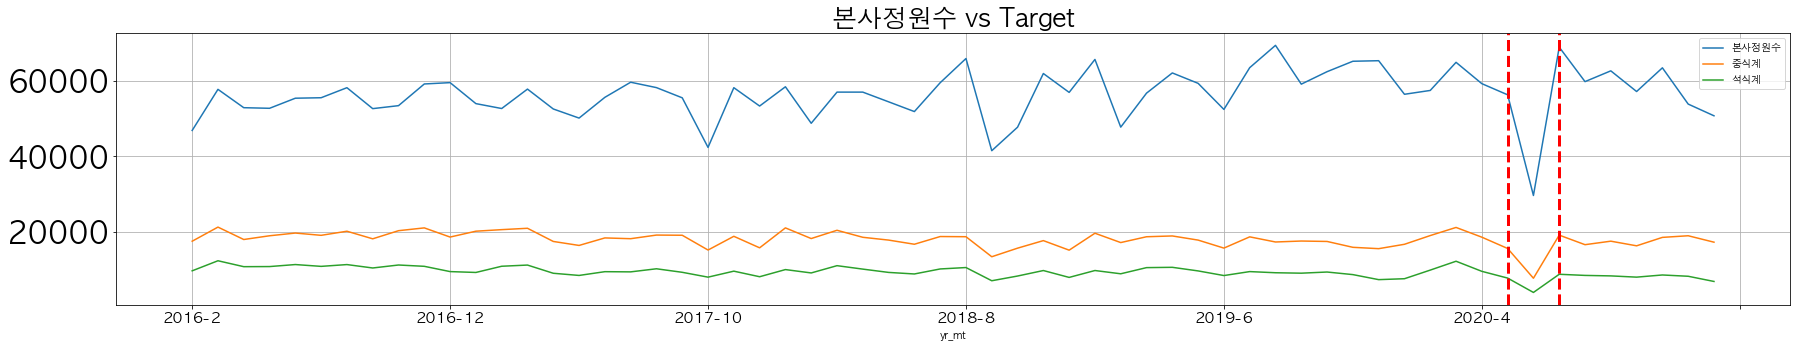

In [351]:
#본사정원수에 따른 중석식계의 영향은?
mt_wk_emp = train.groupby(['year','month'])['본사정원수','중식계','석식계'].agg('sum').reset_index()
mt_wk_emp['yr_mt'] = mt_wk_emp['year'].astype(str)+ '-' + mt_wk_emp['month'].astype(str)
mt_wk_emp.plot(x = 'yr_mt', y = ['본사정원수', '중식계','석식계'], figsize = (30, 5), grid = True)
plt.xticks(color = "black", fontsize = 15)
plt.axvline(x=51, color='r', linestyle='--', linewidth=3)
plt.axvline(x=53, color='r', linestyle='--', linewidth=3)
plt.title('본사정원수 vs Target', fontsize = 25)
plt.show()

## 시각화결과
    *본사 정원수가 줄어들었기에 중석식계도 감소한 것으로 확인된다.
    의문 : LH는 공기업인데 본사 정원수가 감소한다는 것을 무슨 의미일까?
        은퇴,이직,지사로 이동..?
        감축 방안은 △상위 관리직 및 지원부서 감축(226명) △기능이관 및 폐지(519명) △기능축소(330명) 등이다
        (http://www.gnnews.co.kr/news/articleView.html?idxno=476594)
        >그렇다면 이것을 변수로 생성할 수 있을까?

In [402]:
for i in range(1,len(train)):
    a =[]
    a[i] = train.본사정원수[i+1] - train.본사정원수[i]
    
return a

IndexError: list assignment index out of range

In [18]:
#변수들의 실제 비율을 알고자 변수 생성
train['휴가비율'] = train.본사휴가자수 / train.본사정원수
train['출장비율'] = train.본사출장자수 / train.본사정원수
train['야근비율'] = train.본사시간외근무명령서승인건수 / train.본사정원수
train['재택근무비율'] = train.현본사소속재택근무자수 / train.본사정원수

test['휴가비율'] = test.본사휴가자수 / test.본사정원수
test['출장비율'] = test.본사출장자수 / test.본사정원수
test['야근비율'] = test.본사시간외근무명령서승인건수 / test.본사정원수
test['재택근무비율'] = test.현본사소속재택근무자수 / test.본사정원수

In [16]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   요일              1205 non-null   int64  
 1   본사정원수           1205 non-null   int64  
 2   본사휴가자수          1205 non-null   int64  
 3   본사출장자수          1205 non-null   int64  
 4   본사시간외근무명령서승인건수  1205 non-null   int64  
 5   현본사소속재택근무자수     1205 non-null   float64
 6   중식계             1205 non-null   float64
 7   석식계             1205 non-null   float64
 8   year            1205 non-null   int64  
 9   month           1205 non-null   int64  
 10  day             1205 non-null   int64  
 11  내부근무자수          1205 non-null   float64
 12  휴가비율            1205 non-null   float64
 13  출장비율            1205 non-null   float64
 14  야근비율            1205 non-null   float64
 15  재택근무비율          1205 non-null   float64
 16  중식참여율           1205 non-null   float64
 17  석식참여율           1205 non-null   f

In [ ]:
sns.bar.plot(train,x = '')

In [ ]:

#일자 drop
train.drop('일자',axis = 1,inplace = True)
test.drop('일자',axis = 1,inplace = True)